# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [134]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [135]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Capstone Data Science") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [136]:
df = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [161]:
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', churn=0)]

In [138]:
# Print out the data schema 
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [179]:
df.select("page").show()

+---------------+
|           page|
+---------------+
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|Add to Playlist|
|       NextSong|
|       NextSong|
|    Roll Advert|
|       NextSong|
|       NextSong|
|      Thumbs Up|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
|       NextSong|
+---------------+
only showing top 20 rows



In [139]:
# Display each features statistics 
for column in df.columns: 
    df.describe(column).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161377|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev| 129.7672620114106|
|    min|                 0|
|    max| 

In [140]:
## Drop rows with missing values for userID and SessionID
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [141]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [142]:
# filter for users with blank user id
blank_pages = df.filter(df.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

In [143]:
# get a list of possible pages that could be visited
all_pages = df.select("page").dropDuplicates()

In [180]:
all_pages.collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [144]:
# find values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

Logout
Submit Downgrade
Cancel
Thumbs Up
NextSong
Roll Advert
Add Friend
Settings
Downgrade
Thumbs Down
Upgrade
Cancellation Confirmation
Save Settings
Add to Playlist
Submit Upgrade


In [145]:
## Convert epoch time to date time 
## User defined function to convert epoctime to datetime 
get_hour = udf(lambda x : datetime.datetime.fromtimestamp(x / 1000). hour)
## Convert ts to datetime and add as new column hour
df = df.withColumn("hour",get_hour(df.ts))

In [146]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2')]

In [147]:
## Only look at valid users 
df_valid = df.filter(df["userId"] != "")

In [148]:
# Number of songs played from the most played artist
df.filter(df.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(3)

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
+--------------------+-----------+
only showing top 3 rows



In [149]:
# Find when users Submit Cancellation Confirmation
df.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|  22|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/

In [181]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [182]:
# Add churn (cancel confirmation) column 
df = df.withColumn("churn", flag_churn_event("page"))

# Add downgrade column
df = df.withColumn("downgrade", flag_downgrade_event("page"))

In [183]:
# Number of cancellations per hour 
cancel_in_hour = df.filter(df.page =="Cancellation Confirmation").groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [184]:
cancel_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|    2|
|   1|    2|
|   2|    3|
|   4|    1|
|   5|    3|
|   6|    2|
|   8|    2|
|   9|    5|
|  11|    1|
|  12|    2|
|  13|    1|
|  14|    2|
|  15|    1|
|  16|    1|
|  17|    5|
|  18|    2|
|  19|    3|
|  20|    5|
|  21|    3|
|  22|    3|
+----+-----+
only showing top 20 rows



In [154]:
cancel_in_hour_pd = cancel_in_hour.toPandas()
cancel_in_hour_pd.hour = pd.to_numeric(cancel_in_hour_pd.hour)

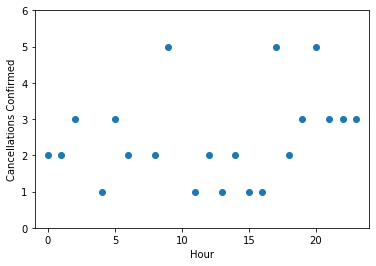

In [155]:
# When does users cancel their accounts ? 
plt.scatter(cancel_in_hour_pd["hour"], cancel_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(cancel_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Cancellations Confirmed");

In [ ]:
## Create a feature of number of days a user has been using

In [ ]:
### se gjennom maskinlæring forelesningen 

### les gjennom prosjektbeskrivelsen 

### Make columns out of Thumbs up etc. 

### Explore more around use pattern

### Divide into churn data set and analyse these (sjekk ut denne dataen i pandas?)

## tenk på features 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
"""Ideas for features 

1. Time before cancellation 
2. Number of songs played before cancellation 
3. Number of days a user has used the service (from registration)
4. Time since downgrade 
5. Downgrade events 
6. Time between use
7. Time spent using serivce 
8. Number of unique songs played per use 
9. 


"""


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.